In [111]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/crimes-in-boston/offense_codes.csv
/kaggle/input/crimes-in-boston/crime.csv


Data Exploration

In [112]:
# Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Import data
data = pd.read_csv('../input/crimes-in-boston/crime.csv', encoding='latin-1')

# Peek
data.head()

,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,I182070945,619,Larceny,LARCENY ALL OTHERS,D14,808,NaN,2018-09-02 13:00:00,2018,9,Sunday,13,Part One,LINCOLN ST,42.357791,-71.139371,"(42.35779134, -71.13937053)"
1,I182070943,1402,Vandalism,VANDALISM,C11,347,NaN,2018-08-21 00:00:00,2018,8,Tuesday,0,Part Two,HECLA ST,42.306821,-71.060300,"(42.30682138, -71.06030035)"
2,I182070941,3410,Towed,TOWED MOTOR VEHICLE,D4,151,NaN,2018-09-03 19:27:00,2018,9,Monday,19,Part Three,CAZENOVE ST,42.346589,-71.072429,"(42.34658879, -71.07242943)"
3,I182070940,3114,Investigate Property,INVESTIGATE PROPERTY,D4,272,NaN,2018-09-03 21:16:00,2018,9,Monday,21,Part Three,NEWCOMB ST,42.334182,-71.078664,"(42.33418175, -71.07866441)"
4,I182070938,3114,Investigate Property,INVESTIGATE PROPERTY,B3,421,NaN,2018-09-03 21:05:00,2018,9,Monday,21,Part Three,DELHI ST,42.275365,-71.090361,"(42.27536542, -71.09036101)"


First, let's clean up and simplify this data set. I am going to focus on the two years with complete data (2016 and 2017). I will also narrow in on UCR Part One offenses, which include only the most serious crimes.

In [113]:
# Keep only data from complete years (2016, 2017)
data = data.loc[data['YEAR'].isin([2016,2017])]

# Keep only data on UCR Part One offenses
data = data.loc[data['UCR_PART'] == 'Part One']

# Remove unused columns
data = data.drop(['INCIDENT_NUMBER','OFFENSE_CODE','UCR_PART','Location'], axis=1)

# Convert OCCURED_ON_DATE to datetime
data['OCCURRED_ON_DATE'] = pd.to_datetime(data['OCCURRED_ON_DATE'])

# Fill in nans in SHOOTING column
data.SHOOTING.fillna('N', inplace=True)

# Convert DAY_OF_WEEK to an ordered category
data.DAY_OF_WEEK = pd.Categorical(data.DAY_OF_WEEK, 
              categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
              ordered=True)

# Replace -1 values in Lat/Long with Nan
data.Lat.replace(-1, None, inplace=True)
data.Long.replace(-1, None, inplace=True)

# Rename columns to something easier to type (the all-caps are annoying!)
rename = {'OFFENSE_CODE_GROUP':'Group',
         'OFFENSE_DESCRIPTION':'Description',
         'DISTRICT':'District',
         'REPORTING_AREA':'Area',
         'SHOOTING':'Shooting',
         'OCCURRED_ON_DATE':'Date',
         'YEAR':'Year',
         'MONTH':'Month',
         'DAY_OF_WEEK':'Day',
         'HOUR':'Hour',
         'STREET':'Street'}
data.rename(index=str, columns=rename, inplace=True)

# Check
data.head()

,Group,Description,District,Area,Shooting,Date,Year,Month,Day,Hour,Street,Lat,Long
5633,Larceny,LARCENY THEFT FROM BUILDING,E5,729,N,2017-10-23 13:58:00,2017,10,Monday,13,VFW PKWY,42.285370,-71.172440
5919,Auto Theft,AUTO THEFT - MOTORCYCLE / SCOOTER,E18,544,N,2017-03-22 09:00:00,2017,3,Wednesday,9,AUSTIN ST,42.257688,-71.126418
6940,Residential Burglary,BURGLARY - RESIDENTIAL - NO FORCE,D14,774,N,2017-03-23 12:00:00,2017,3,Thursday,12,COMMONWEALTH AVE,42.338363,-71.154410
12370,Larceny From Motor Vehicle,LARCENY THEFT FROM MV - NON-ACCESSORY,E13,571,N,2017-11-21 21:00:00,2017,11,Tuesday,21,SYLVIA ST,42.310559,-71.102854
14227,Larceny,LARCENY THEFT FROM BUILDING,D4,136,N,2017-12-15 16:06:00,2017,12,Friday,16,MARLBOROUGH ST,42.352569,-71.079788


In [114]:
# A few more data checks
data.dtypes
data.isnull().sum()
data.shape

(37538, 13)

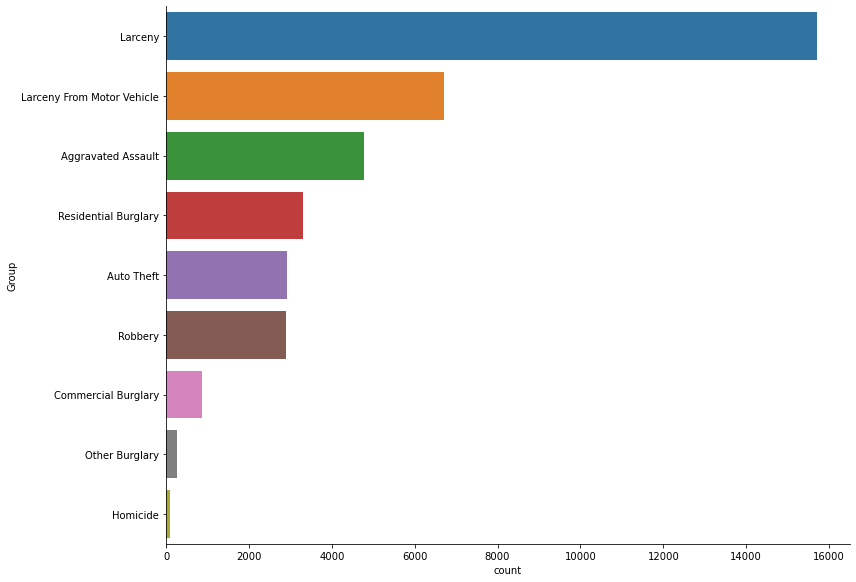

In [115]:
# Countplot for crime types
sns.catplot(y='Group',
           kind='count',
            height=8, 
            aspect=1.5,
            order=data.Group.value_counts().index,
           data=data)

Larceny is by far the most common serious crime, and homicides are pretty rare

# **When do serious crimes occur?**
We can consider patterns across several different time scales: hours of the day, days of the week, and months of the year.

Text(-2.6999999999999957, 0.5, 'Count')

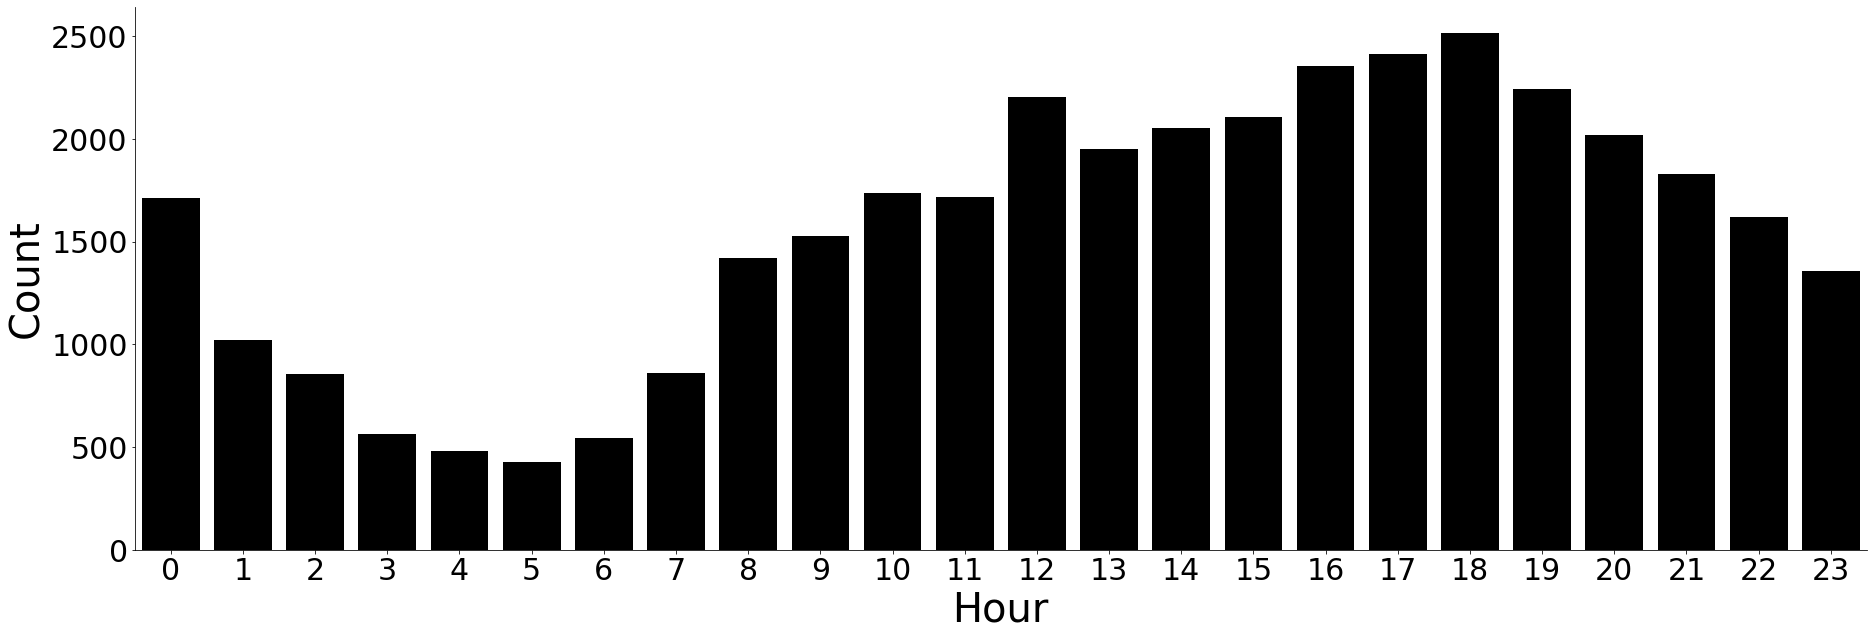

In [116]:
# Crimes by hour of the day
sns.catplot(x='Hour',
           kind='count',
            height=8.27, 
            aspect=3,
            color='black',
           data=data)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('Hour', fontsize=40)
plt.ylabel('Count', fontsize=40)

Text(-2.6999999999999886, 0.5, 'Count')

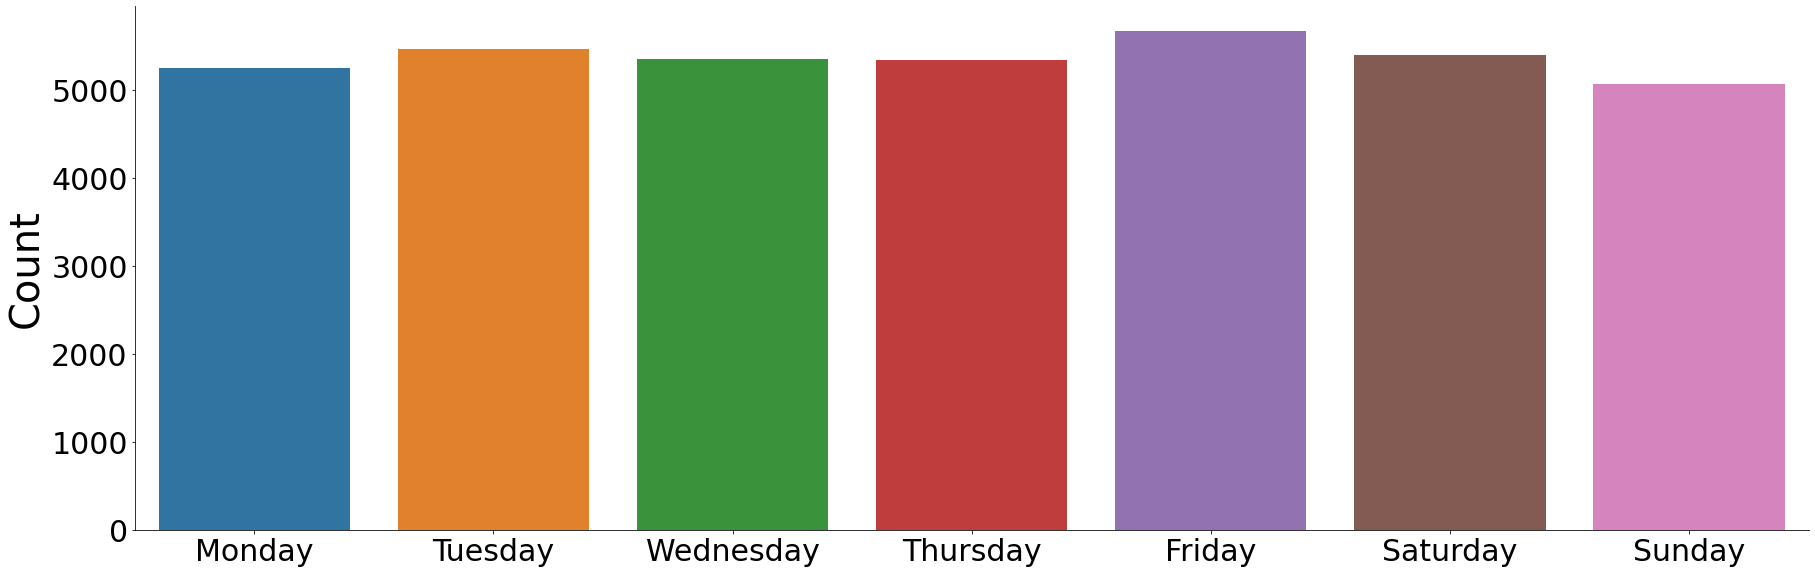

In [117]:
# Crimes by day of the week
sns.catplot(x='Day',
           kind='count',
            height=8, 
            aspect=3,
           data=data)
plt.xticks(size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

Text(-2.6999999999999886, 0.5, 'Count')

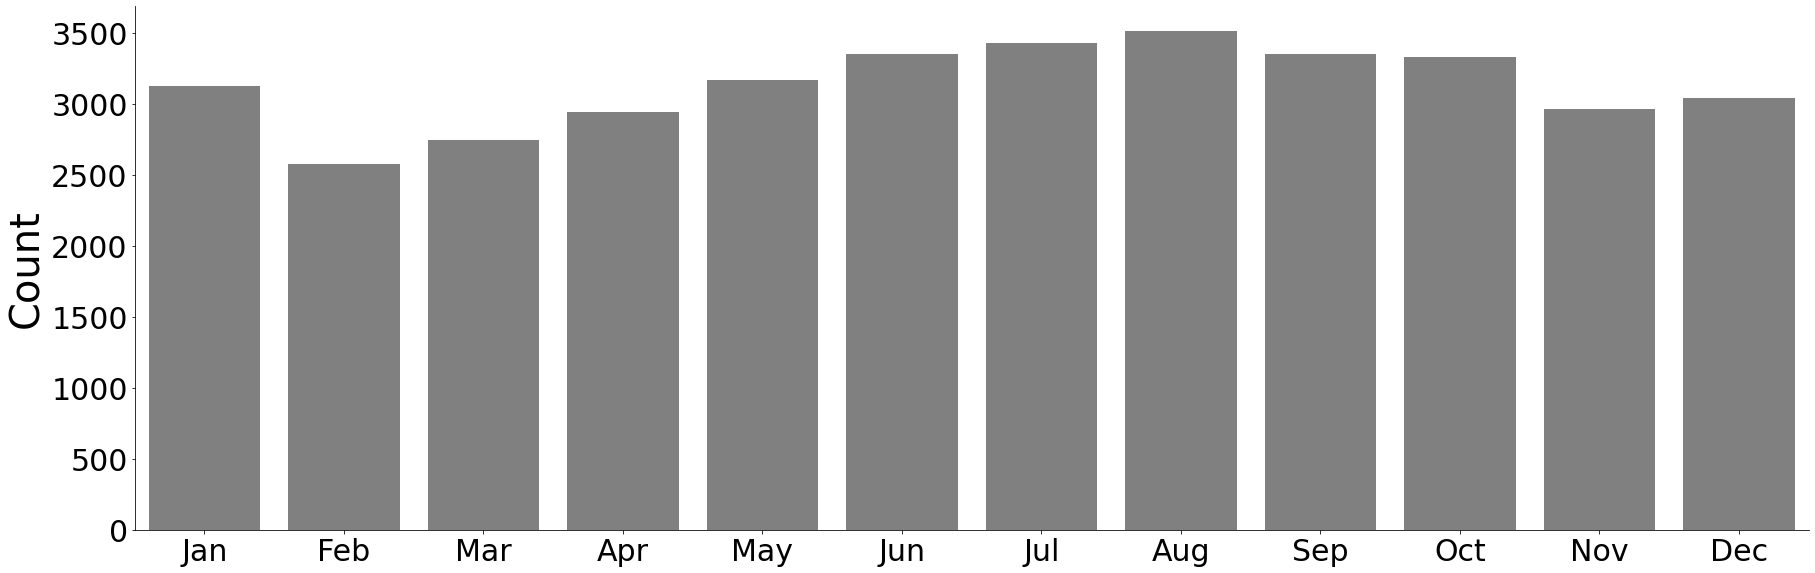

In [118]:
# Crimes by month of year
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
sns.catplot(x='Month',
           kind='count',
            height=8, 
            aspect=3,
            color='gray',
           data=data)
plt.xticks(np.arange(12), months, size=30)
plt.yticks(size=30)
plt.xlabel('')
plt.ylabel('Count', fontsize=40)

Crimes rates are low between 1-8 in the morning, and gradually rise throughout the day, peaking around 6 pm. There is some variation across days of the week, with Friday having the highest crime rate and Sunday having the lowest. The month also seems to have some influence, with the winter months of February-April having the lowest crime rates, and the summer/early fall months of June-October having the highest crime rates. There is also a spike in crime rates in the month of January.

Are any other temporal factors associated with crime? According to some crime experts, several types of crime tend to increase around the holidays, particularly larsony and robbery. This can occur for many reasons: crowded shopping centers create more cover for thieves, travelers leave their homes vulnerable to burglary, and increased alcohol and drug use can raise the likelihood of conflict-related crime. Let's see if there is any evidence for this in our data, focusing in on the year 2017. I also added in a couple of days that are known to be especially rowdy in Boston, even though they aren't official holidays: St. Patrick's Day and the Boston Marathon.

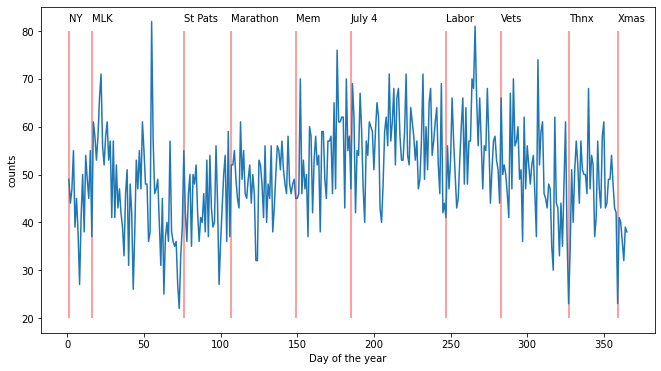

In [119]:
# Create data for plotting
data['Day_of_year'] = data.Date.dt.dayofyear
data_holidays = data[data.Year == 2017].groupby(['Day_of_year']).size().reset_index(name='counts')

# Dates of major U.S. holidays in 2017
holidays = pd.Series(['2017-01-01', # New Years Day
                     '2017-01-16', # MLK Day
                     '2017-03-17', # St. Patrick's Day
                     '2017-04-17', # Boston marathon
                     '2017-05-29', # Memorial Day
                     '2017-07-04', # Independence Day
                     '2017-09-04', # Labor Day
                     '2017-10-10', # Veterans Day
                     '2017-11-23', # Thanksgiving
                     '2017-12-25']) # Christmas
holidays = pd.to_datetime(holidays).dt.dayofyear
holidays_names = ['NY',
                 'MLK',
                 'St Pats',
                 'Marathon',
                 'Mem',
                 'July 4',
                 'Labor',
                 'Vets',
                 'Thnx',
                 'Xmas']

import datetime as dt
# Plot crimes and holidays
fig, ax = plt.subplots(figsize=(11,6))
sns.lineplot(x='Day_of_year',
            y='counts',
            ax=ax,
            data=data_holidays)
plt.xlabel('Day of the year')
plt.vlines(holidays, 20, 80, alpha=0.5, color ='r')
for i in range(len(holidays)):
    plt.text(x=holidays[i], y=82, s=holidays_names[i])

Hm, I'm not seeing any clear signals here. In fact, many of these holidays appear to line up with especially low crime rates, particularly Thanksgiving and Christmas. Of course, this is data from just a single year, and detecting an association between a given holiday and crime rates would require a lot more data and a model that accounts for other factors. However, this does cause me to question the general idea that crime increases surrounding holidays - if that is true, it isn't super obvious from a birds-eye view of the data. Even the entire "holiday season" from Thanksgiving to Christmas doesn't seem to be especially elevated compared to the summer.

# Where do serious crimes occur?
We can use the latitude and longitude columns to plot the location of crimes in Boston. By setting the alpha parameter to a very small value, we can see that there are some crime 'hotspots'

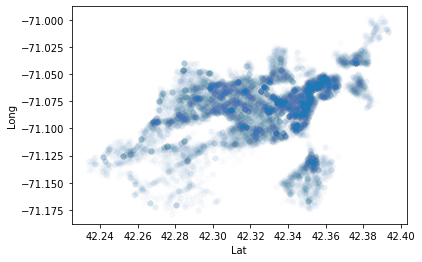

In [120]:
# Simple scatterplot
sns.scatterplot(x='Lat',
               y='Long',
                alpha=0.01,
               data=data)

That looks like Boston alright. If you are at all familiar with Boston, you will not be too surprised to see that downtown Boston has the darkest points, but there are also some localities outside of the city center that have especially high crime rates.

Let's make another scatterplot, but this time we'll color points by district to see which districts have the highest crime rates.

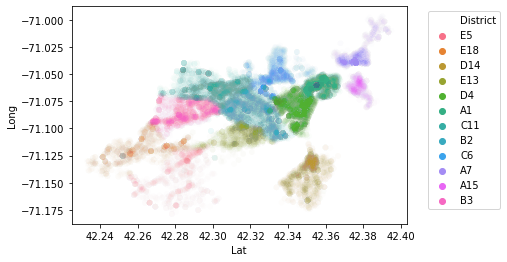

In [121]:
# Plot districts
sns.scatterplot(x='Lat',
               y='Long',
                hue='District',
                alpha=0.01,
               data=data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

We can now associate high crime rates with particular districts, most noteably A1 and D4, which correspond to the most crowded areas of downtown Boston. There is also a very high crime region visibe in district D14.

Let's make things pretty by using Folium to make an interactive heatmap of Boston crimes. I will use the 2017 data only for this plot.

In [122]:
crime_map = folium.Map(location=[42.3125,-71.0875], 
                       tiles = "Stamen Toner",
                      zoom_start = 11)

# Add data for heatmp 
data_heatmap = data[data.Year == 2017]
data_heatmap = data[['Lat','Long']]
data_heatmap = data.dropna(axis=0, subset=['Lat','Long'])
data_heatmap = [[row['Lat'],row['Long']] for index, row in data_heatmap.iterrows()]
HeatMap(data_heatmap, radius=10).add_to(crime_map)

# Plot!
crime_map

# Conclusions
In summary, this EDA shows:

Larceny is by far the most common type of serious crime.
Serious crimes are most likely to occur in the afternoon and evening.
Serious crimes are most likely to occur on Friday and least likely to occur on Sunday.
Serious crimes are most likely to occur in the summer and early fall, and least likely to occur in the winter (with the exeption of January, which has a crime rate more similar to the summer).
There is no obvious connection between major holidays and crime rates.
Serious crimes are most common in the city center, especially districts A1 and D4.
This EDA just scratches the surface of the dataset. Further analyses could explore how different types of crimes vary in time and space. I didn't even consider the less serious UCR Part Two and Part Three crimes, which are far more common than Part One crimes, but include interesting categories such as drug crimes. Another interesting direction would be to combine this with other data about Boston, such as demography or even the weather, to investigate what factors predict crime rates across time and space.